Представим, что международное круизное агентство Carnival Cruise Line решило себя разрекламировать с помощью баннеров и обратилось для этого к вам. Чтобы протестировать, велика ли от таких баннеров польза, их будет размещено всего 20 штук по всему миру. Вам надо выбрать 20 таких локаций для размещения, чтобы польза была большой и агентство продолжило с вами сотрудничать.
Агентство крупное, и у него есть несколько офисов по всему миру. Вблизи этих офисов оно и хочет разместить баннеры — легче договариваться и проверять результат. Также эти места должны быть популярны среди туристов.
Для поиска оптимальных мест воспользуемся базой данных крупнейшей социальной сети, основанной на локациях — Foursquare.

In [91]:
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from operator import itemgetter
from matplotlib.markers import MarkerStyle
from sklearn.cluster import MeanShift
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable


pd.options.display.float_format = '{:.5f}'.format

In [33]:
DATA_FILE = '/Users/macair/Python Projects/CourseraML3/umn_foursquare_datasets/checkins.dat'
data = pd.read_csv(DATA_FILE, skipinitialspace=True, sep='|')
data.dropna(axis=0, inplace=True)
data.shape

/Users/macair/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(396634, 6)

In [3]:
data.head(10)

,id,user_id,venue_id,latitude,longitude,created_at
2,984222,15824.00000,5222.00000,38.89511,-77.03637,2012-04-21 17:43:47
4,984234,44652.00000,5222.00000,33.80074,-84.41052,2012-04-21 17:43:43
8,984291,105054.00000,5222.00000,45.52345,-122.67621,2012-04-21 17:39:22
10,984318,2146539.00000,5222.00000,40.76446,-111.90456,2012-04-21 17:35:46
11,984232,93870.00000,380645.00000,33.44838,-112.07404,2012-04-21 17:38:18
12,984483,1030290.00000,955969.00000,32.22174,-110.92648,2012-04-21 17:58:54
13,984685,304253.00000,23558.00000,40.65000,-73.95000,2012-04-21 18:19:34
14,984470,720850.00000,749715.00000,33.44838,-112.07404,2012-04-21 17:02:47
16,984610,1639666.00000,442605.00000,33.41477,-111.90931,2012-04-21 18:04:58
19,984653,1647192.00000,23558.00000,42.35843,-71.05977,2012-04-21 18:23:22


In [4]:
data.describe()

,user_id,venue_id,latitude,longitude
count,396634.00000,396634.00000,396634.00000,396634.00000
mean,564134.91281,132755.94129,37.09707,-86.35407
std,486569.41280,228700.30154,8.77876,37.98368
min,1.00000,1.00000,-75.25097,-159.67083
25%,169290.00000,7620.00000,33.80074,-111.92605
50%,429820.00000,28304.00000,39.09928,-85.75846
75%,849647.00000,148552.00000,40.80207,-74.05653
max,2153361.00000,1143011.00000,78.21859,178.42424


In [5]:
X = data.iloc[:, 3:5].values[:10000]
X.shape

(10000, 2)

In [6]:
X.min(axis=0), X.max(axis=0), X.std(axis=0), X.mean(axis=0)

(array([ -36.8484597, -158.056892 ]),
 array([ 67.6314789, 174.7633315]),
 array([ 7.4977736 , 30.10469603]),
 array([ 36.47974494, -95.01178031]))

In [7]:
class MeanShift:
    def __init__(self):
        pass

    def euclidian(self, x, xi):
        return np.linalg.norm(x - xi, axis=1, keepdims=True)

    def neighbours(self, X, x_centered, dist=None):
        dists = self.euclidian(X, x_centered)
        return dists[np.all(dists <= dist, axis=1)] if dist is None else dists

    def gaussian(self, dist, std):
        return (1 / (std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * np.power(dist / std, 2))

    def _shift(self, X, x, bandwidth, dist=None):
        dists = self.neighbours(X, x, dist)
        weight = self.gaussian(dists, bandwidth)
        return np.multiply(X, weight).sum(axis=0) / weight.sum(axis=0)

    def _optimize(self, X, X_init):
        # ToDO
        return

    def _classes(self, n_classes):
        sorted_centroids = np.array(sorted(self.centroids, key=itemgetter(*range(self.centroids.shape[1]))))
        X = abs(sorted_centroids).mean(axis=1)
        classes = defaultdict()
        left_i = 0
        for n_cls, i in enumerate(np.linspace(X.min(), X.max(), n_classes)):
            classes[n_cls] = sorted_centroids[np.logical_and(X >= left_i, X <= i), :]
            left_i = i

        self.classes = classes

    def fit(self, X, n_classes=None, max_iter=3, radius=None, bandwidth=0.5):
        X_init = np.copy(X)
        optimized = False
        for _ in range(max_iter):
            radius = np.abs(2 * X_init.std(axis=0))
            for i in range(X_init.shape[0]):
                X_init[i] = self._shift(X, X_init[i], bandwidth, radius)

        self.centroids = X_init
        
        if n_classes:
            self._classes(n_classes)
    def cls_probs(self):

        probs = defaultdict()
        for c, v in self.classes.items():
            x, y = v[:,0], v[:, 1]
            x_min, x_max = x.min(), x.max()
            y_min, y_max = y.min(), y.max()
            xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50), np.linspace(y_min, y_max, 50))
            x_centeroid = (xx + yy).mean(axis=0)
            dists = self.euclidian(np.hstack(xx, yy), x_centeroid)
            weight = self.gaussian(dists, dists.std(axis=0))
            
            # x_centeroid = v.mean(axis=0)
            # dists = self.euclidian(v, x_centeroid)
            # weight = self.gaussian(dists, dists.std(axis=0))
            probs[c] = weight

        self.probs = probs

In [8]:
n_classes, max_iter, radius, bandwidth = 2, 10, None, 7

In [208]:
%%time
meanshift = MeanShift()
meanshift.fit(X, n_classes, max_iter, radius, bandwidth)

CPU times: user 48.5 s, sys: 1.19 s, total: 49.6 s
Wall time: 50.8 s


In [209]:
classes = meanshift.classes

In [210]:
centroids = np.array(meanshift.centroids)

In [211]:
centroids.min(axis=0), centroids.max(axis=0), centroids.std(axis=0), centroids.mean(axis=0)

(array([ -36.81643578, -157.38228321]),
 array([ 62.36844302, 174.50308344]),
 array([ 6.41566074, 29.97506026]),
 array([ 36.31278606, -94.0450174 ]))

In [212]:
classes = meanshift.classes

In [213]:
meanshift.cls_probs()
probs = meanshift.probs

TypeError: hstack() takes 1 positional argument but 2 were given

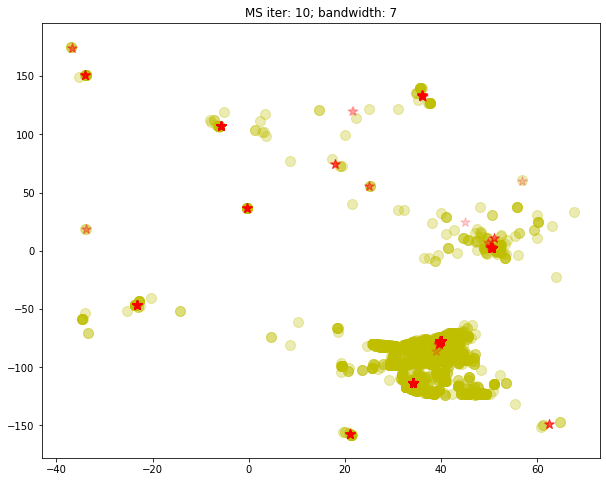

In [204]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], color='y', s=100, alpha=0.3)
plt.scatter(centroids[:, 0], centroids[:, 1], color='r', marker='*', s=100, alpha=0.2)
plt.title(f'MS iter: {max_iter}; bandwidth: {bandwidth}')
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], color='gray', s=100, alpha=0.1, marker='.')

cmap = iter(cm.rainbow(np.linspace(0, 1, n_classes)))
markers = MarkerStyle.markers
markers = iter(list(filter(lambda k: not str(k).isdigit() and k not in [None, 'None', ' ', '', '>', '<'], markers.keys())))
for it, (c, v) in enumerate(classes.items()):
    plt.scatter(v[:, 0], v[:, 1], color=next(cmap), marker=next(markers), s=100, alpha=0.4, label=f'cls{it}')
#     plt.contour(v[:, 0], v[:, 1], probs[c])

plt.title(f'MS iter: {max_iter}; bandwidth: {bandwidth}')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.legend()
plt.show()

In [21]:
bandwidth = 0.1
min_freq = 15
meanshift = MeanShift(bandwidth=bandwidth, n_jobs=2)

In [22]:
n = 100000
X = data.iloc[:n, 3:5].values

In [23]:
%%time
meanshift.fit(X)

CPU times: user 23.1 s, sys: 4.75 s, total: 27.9 s
Wall time: 8min 57s


MeanShift(bandwidth=0.1, bin_seeding=False, cluster_all=True, min_bin_freq=1,
          n_jobs=2, seeds=None)

In [24]:
labels = meanshift.labels_
centers = meanshift.cluster_centers_

In [25]:
classes, counts = np.unique(labels, return_counts=True)
inds = np.where(counts > min_freq)

In [75]:
max_dense_cls = 50
cls = classes[:max_dense_cls]

In [74]:
pred_c = meanshift.predict(X)

In [76]:
cls_s, counts = np.unique(pred_c, return_counts=True)

In [73]:
counts[:50].sum(), counts[30:].sum()

(52826, 46580)

In [77]:
pred_c[np.isin(pred_c, range(max_dense_cls), invert=True)] =  max_dense_cls + 1

In [78]:
np.unique(pred_c, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 51]),
 array([12506,  4692,  3994,  3363,  3526,  2409,  2297,  1601,  1526,
         1378,  1298,  1081,  1006,  1007,   714,   868,   870,   645,
          808,   807,   612,   722,   754,   747,   539,   656,   580,
          577,   679,   564,   594,   907,   449,   502,   452,   104,
          431,   410,   388,   400,   369,   367,   384,   347,   345,
          342,   314,   273,   314,   316, 39166]))

In [79]:
cmap = cm.get_cmap('viridis', cls.size + 1)

In [80]:
print(pred_c.size)
cmap(pred_c)[:3]
X.shape

100000


(100000, 2)

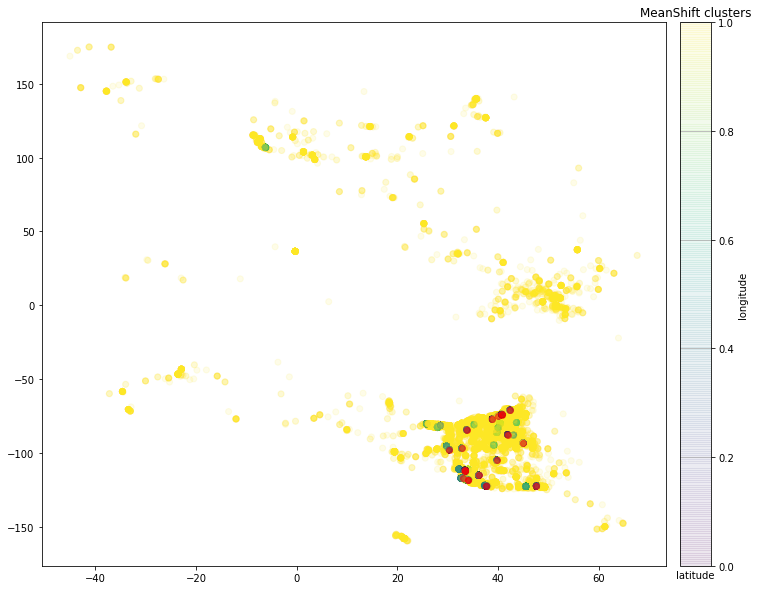

In [98]:
fig, ax = plt.subplots(figsize=(12, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
pic = ax.scatter(X[:, 0], X[:, 1], c=cmap(pred_c), alpha=0.1)
ax.scatter(centers[:20, 0], centers[:20, 1], alpha=0.5, color='r', label='centroids')
plt.colorbar(pic, cax=cax)
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.title('MeanShift clusters')
plt.grid()
plt.show()

In [18]:
centers[inds]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])